In [1]:
import sys
sys_path = 'D:/Research_CAE/MyTinyCUDANN/tiny-cuda-nn/main'
sys.path.append(sys_path)
from my_tiny_cuda import my_MLP
from tools import random_points_1D,collocation_points_1D
from gradient import grad1, grad2
import tinycudann as tcnn
import torch
import numpy as np
import json
device = 'cuda'

In [2]:
def generate_grid_points(resolution, field_min = 0, field_max = 1):
    x1_list = np.linspace(field_min, field_max, resolution)
    x2_list = np.linspace(field_min, field_max, resolution)
    X1,X2 = np.meshgrid(x1_list,x2_list)
    X_field = torch.tensor(np.concatenate((X1.reshape(-1,1),X2.reshape(-1,1)),
    axis = 1)).float().to(device)
    return X_field

def sample_all_boundary(batch_size_BC,field_min = 0, field_max = 1):
    n00 = torch.tensor([field_min,field_min])
    n01 = torch.tensor([field_min,field_max])
    n10 = torch.tensor([field_max,field_min])
    n11 = torch.tensor([field_max,field_max])
    X_bot = random_points_1D(int(batch_size_BC),n00,n10)
    X_left = random_points_1D(int(batch_size_BC),n00,n01)
    X_right = random_points_1D(int(batch_size_BC),n10,n11)
    X_top = random_points_1D(int(batch_size_BC),n01,n11)
    X_boundaries = torch.cat((X_bot,X_left,X_top,X_right), dim = 0)
    return X_boundaries

class Wave_equation(torch.nn.Module):
    def __init__(self,c = 1.0, L = 1):
        super().__init__()
        self.c = c
        self.c2 = c**2
        self.L = L
    def strong_form(self,x,grad_result):
        d2u_dt2,d2u_dx2 = grad_result["d2u_dx2"],grad_result["d2u_dy2"]
        result = d2u_dt2 - self.c2*d2u_dx2
        return result
    def variational_energy(self,X,u,du_dt,du_dx):
        # result = 1/2*(du_dt**2 +self.k* du_dx**2)
        result = 0.5*(du_dt**2 - self.c2* du_dx**2)
        return result
    def system_energy(self,X,u,du_dt,du_dx):
        result = 0.5*(du_dt**2 + self.c2* du_dx**2)
        return result
    def BC_function(self,X):
        # return torch.sin(X[:,0]*torch.pi)*torch.sin(X[:,1]*torch.pi)
        return self.real_solution(X)
    def real_solution(self,X):
        # return torch.sin(X[:,1]*torch.pi/self.L)*torch.cos(self.c*X[:,0]*torch.pi/self.L)
        return torch.sin(X[:,1] + self.c*X[:,0])

class modifying_output(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.T_max = 1
        self.X_max = 1
        self.c = 1
    def forward(self,X):
        t,x = X[:,0],X[:,1]
        # u = t * (self.T_max - t) * x * (self.X_max - x) * self.model(X) + torch.sin(x + self.c*t)
        u = torch.sin(t*torch.pi)*torch.sin(x*torch.pi)* self.model(X) + torch.sin(x + self.c*t)
        return u

In [3]:
with open(r"D:\Research_CAE\MyTinyCUDANN\tiny-cuda-nn\main\Wave_equation\Tests\config_1.json") as f:
    config = json.load(f)
# my_mlp = my_MLP(activation = torch.nn.Tanh(), n_input_dims = int(config["encoding"]["n_levels"]*config["encoding"]["n_features_per_level"]),
#             n_hidden = 1, width = 64,
#             spectral_norm = False,dtype = torch.float32).to(device)
# encoding = tcnn.Encoding1(2, config["encoding"],dtype=torch.float32)
# model = modifying_output(torch.nn.Sequential(encoding,my_mlp).to(device))
my_mlp = my_MLP(activation = torch.nn.Tanh(), n_input_dims = 2,
            n_hidden = 2, width = 32,
            spectral_norm = False,dtype = torch.float32).to(device)
model = modifying_output(my_mlp).to(device)
# model = my_mlp
equation = Wave_equation()

In [4]:
boundary_sample_points = sample_all_boundary(1000)
f_boundary = equation.BC_function(boundary_sample_points).to(device)
grid_points_resolution = 100
base_grid_points = generate_grid_points(grid_points_resolution, field_min = 0, field_max = 1 - 1/grid_points_resolution)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# optimizer = torch.optim.LBFGS(model.parameters(),lr = 0.5,
#                             max_iter = 100,line_search_fn="strong_wolfe")
MSELoss = torch.nn.MSELoss().to(device)

In [5]:
lam = 0.1
n_step = 5000
n_step_output = 300
n_step_half_lr = 1000
# n_step = 300
# n_step_output = 10
# n_step_half_lr = 100
model.train()
diff_info = grad1(model,base_grid_points.shape[0])
diff_info.to_device(device)
for i in range(1, n_step+1):
    grid_points = base_grid_points + torch.rand(1,2, device = device)/grid_points_resolution
    def closure():
        global bc_loss, inner_loss, PDE_residual, PDE_energy
        optimizer.zero_grad()
        bc_loss = MSELoss(model(boundary_sample_points),f_boundary)
        du_dt,du_dx,u = diff_info.forward_2d(grid_points)
        PDE_residual = equation.variational_energy(grid_points,u,du_dt,du_dx).mean()
        PDE_energy = torch.median(equation.system_energy(grid_points,u,du_dt,du_dx).view(grid_points_resolution,grid_points_resolution).sum(dim = 0))
        inner_loss =  PDE_residual + lam*PDE_energy #(PDE_residual**2).mean()
        loss = inner_loss #+ lam* bc_loss
        loss.backward()
        return loss
    optimizer.step(closure)
    if i % n_step_output == 0:
        model.eval()
        with torch.no_grad():
            u_error = MSELoss(model(grid_points),equation.real_solution(grid_points))
        print('Iter:',i,'inner_loss:',inner_loss.item(),"\n", 'action:',PDE_residual.item(),'energy:',PDE_energy.item(),
        'bc_loss:',bc_loss.item(),'u_L2:',u_error.item(),)
        model.train()
    
    if i % n_step_half_lr == 0:
        for param_group in optimizer.param_groups:
            param_group['lr'] = param_group['lr']/2
            current_lr = param_group['lr']
        print("lr:{}".format(current_lr))

Iter: 300 inner_loss: 2.311476945877075 
 action: 0.015888119116425514 energy: 22.955886840820312 bc_loss: 0.0 u_L2: 0.002775811590254307
Iter: 600 inner_loss: 2.131270170211792 
 action: 0.017848113551735878 energy: 21.134220123291016 bc_loss: 0.0 u_L2: 0.0018997691804543138
Iter: 900 inner_loss: 2.0164380073547363 
 action: 0.02159259282052517 energy: 19.948453903198242 bc_loss: 0.0 u_L2: 0.002105115680024028
lr:0.0005
Iter: 1200 inner_loss: 1.8831937313079834 
 action: 0.03469099476933479 energy: 18.485027313232422 bc_loss: 0.0 u_L2: 0.002633957890793681
Iter: 1500 inner_loss: 1.8687143325805664 
 action: 0.047242917120456696 energy: 18.21471405029297 bc_loss: 0.0 u_L2: 0.002851045224815607
Iter: 1800 inner_loss: 1.8794856071472168 
 action: 0.04984503239393234 energy: 18.296405792236328 bc_loss: 0.0 u_L2: 0.0031890543177723885
lr:0.00025
Iter: 2100 inner_loss: 1.873620629310608 
 action: 0.05434262380003929 energy: 18.192779541015625 bc_loss: 0.0 u_L2: 0.003391716629266739
Iter: 24

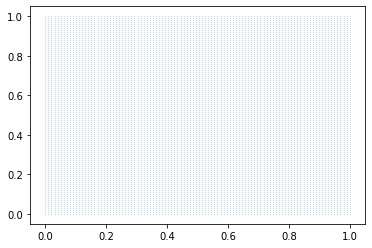

In [12]:
from matplotlib import pyplot as plt
grid_points_plot = grid_points.detach().cpu().numpy()
plt.scatter(grid_points_plot[:,0],grid_points_plot[:,1], s = 0.01)

In [42]:
test_grid_points = (grid_points[:, 0] * 0.001 + grid_points[:, 1]).view(100,100)
torch.median(test_grid_points.sum(dim = 0))

tensor(50.0495, device='cuda:0', grad_fn=<MedianBackward0>)

In [6]:
for param in model.parameters():
    with torch.no_grad():
        param.data.zero_()

In [7]:
model.eval()
with torch.no_grad():
    u_error = MSELoss(model(grid_points),equation.real_solution(grid_points))
u_error

tensor(0., device='cuda:0')

In [8]:
du_dt,du_dx,u = diff_info.forward_2d(grid_points)
PDE_residual = equation.variational_energy(grid_points,u,du_dt,du_dx).mean()
PDE_residual

tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)

In [7]:
equation.real_solution(grid_points).square().mean()

tensor(0.6465, device='cuda:0', grad_fn=<MeanBackward0>)